In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans

def show_img(img):
    plt.figure(figsize=(40,40))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()



images = []

for i in range(1,58):
    image_path = f'./OMR_dataset/images/omr_aiml_dataset_page_{i}.png'
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image,(1700,2624))
    # print(image.shape)
    images.append(image)

images = np.array(images)

phy_images = images[:,1150:1600,:370]
chem_images = images[:,1600:2000,:370]
math_images = images[:,2100:2500,:370]

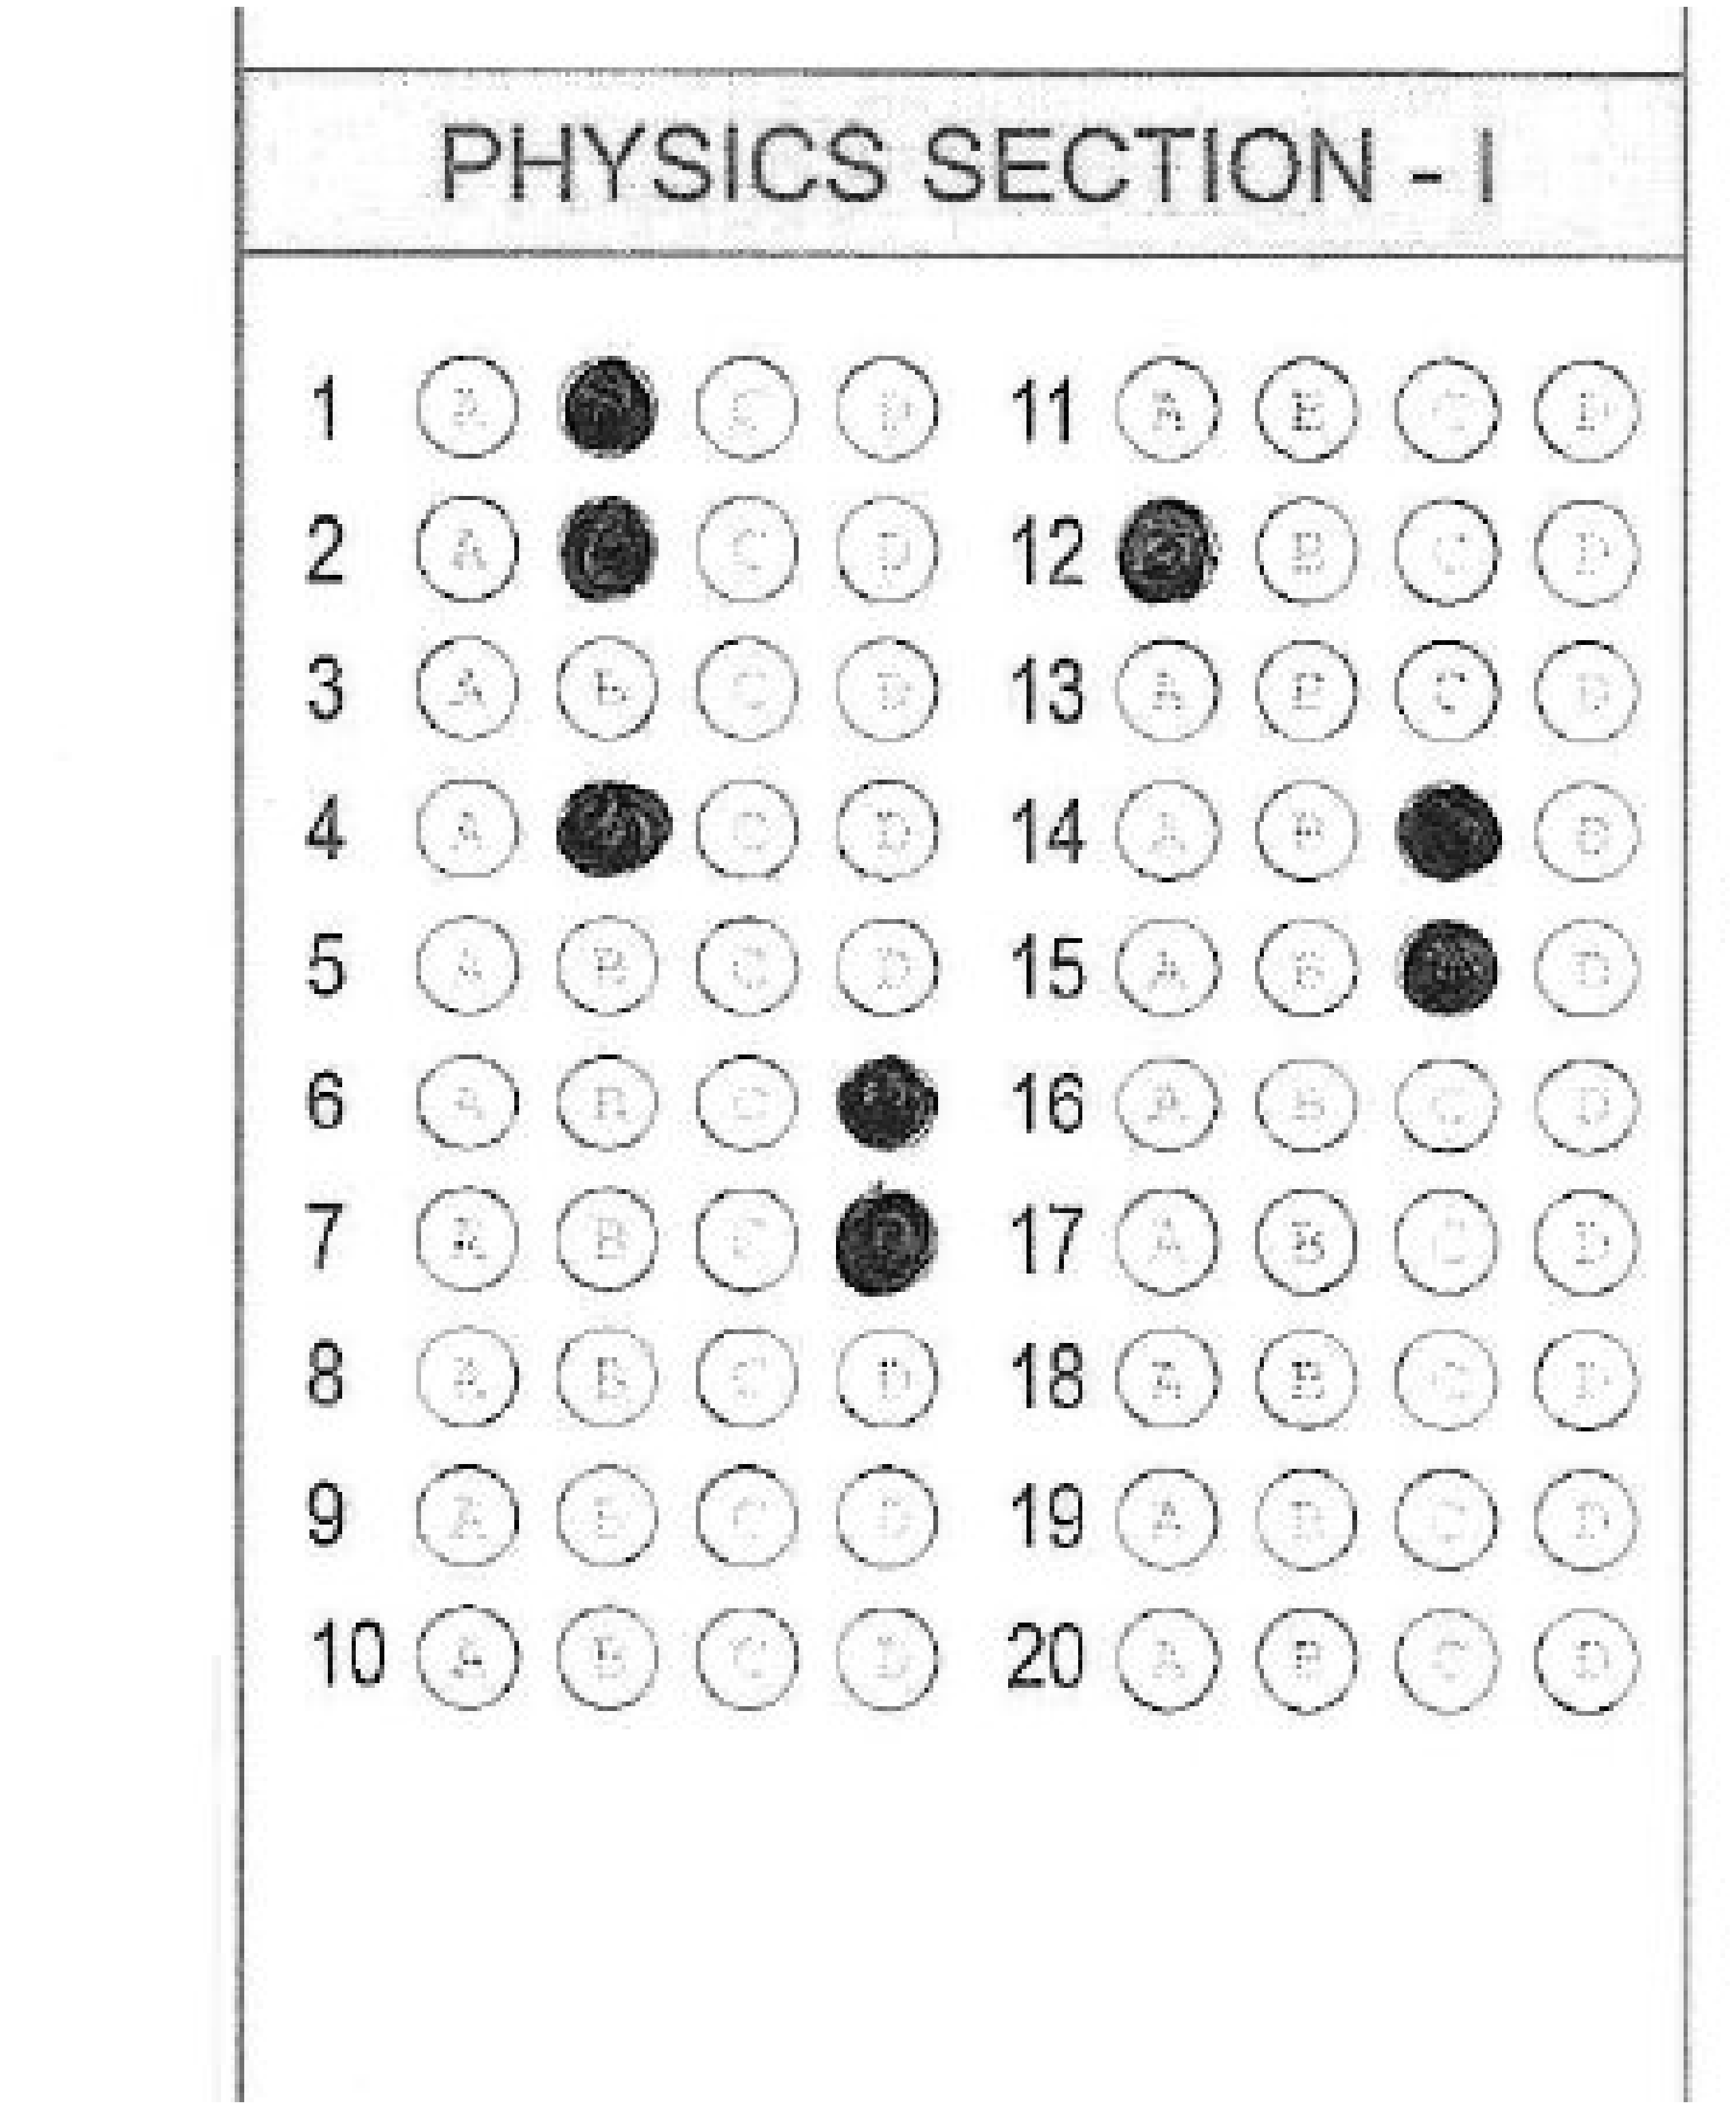

In [2]:
show_img(phy_images[0])

In [3]:
def plotCountours(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert grayscale image to BGR for colored contour drawing
    contour_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Draw all contours in green
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

    show_img(contour_img)


def plotMarkedBulbblesSection(subject):

    # subject = np.where(subject < 225, 255, 0)
    subject = cv2.normalize(subject,None,0,255,cv2.NORM_MINMAX)

    subject = cv2.convertScaleAbs(subject)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(subject, (3, 3), 0)

    # Detect edges using Canny edge detector
    # edges = cv2.Canny(blurred, 50, 100)

    _, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # print(contours)

    bubbles = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        aspect_ratio = w / float(h)

        if w >= 20 and h >= 20 and aspect_ratio >= 0.8 and aspect_ratio <= 1.2:
            bubbles.append(c)

    # print(bubbles)

    image_with_contours = subject.copy()
    image_with_contours = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)
    cv2.drawContours(image_with_contours, bubbles, -1, (0, 255, 0), 2)

    show_img(image_with_contours)

    return bubbles


def plotAllBubblesSection(subject):
    subject = np.where(subject<235,255,0)
    subject = cv2.convertScaleAbs(subject)

    # Apply Gaussian Blur
    # blurred = cv2.GaussianBlur(subject, (3, 3), 0)

    # Detect edges using Canny edge detector
    # edges = cv2.Canny(blurred, 50, 100)

    # _, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(subject, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # print(contours)

    bubbles = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        aspect_ratio = w / float(h)

        if w >= 20 and h >= 20 and aspect_ratio >= 0.8 and aspect_ratio <= 1.2:
            bubbles.append(c)

    # print(bubbles)

    image_with_contours = subject.copy()
    image_with_contours = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)
    cv2.drawContours(image_with_contours, bubbles, -1, (0, 255, 0), 2)

    show_img(image_with_contours)

    

    return bubbles


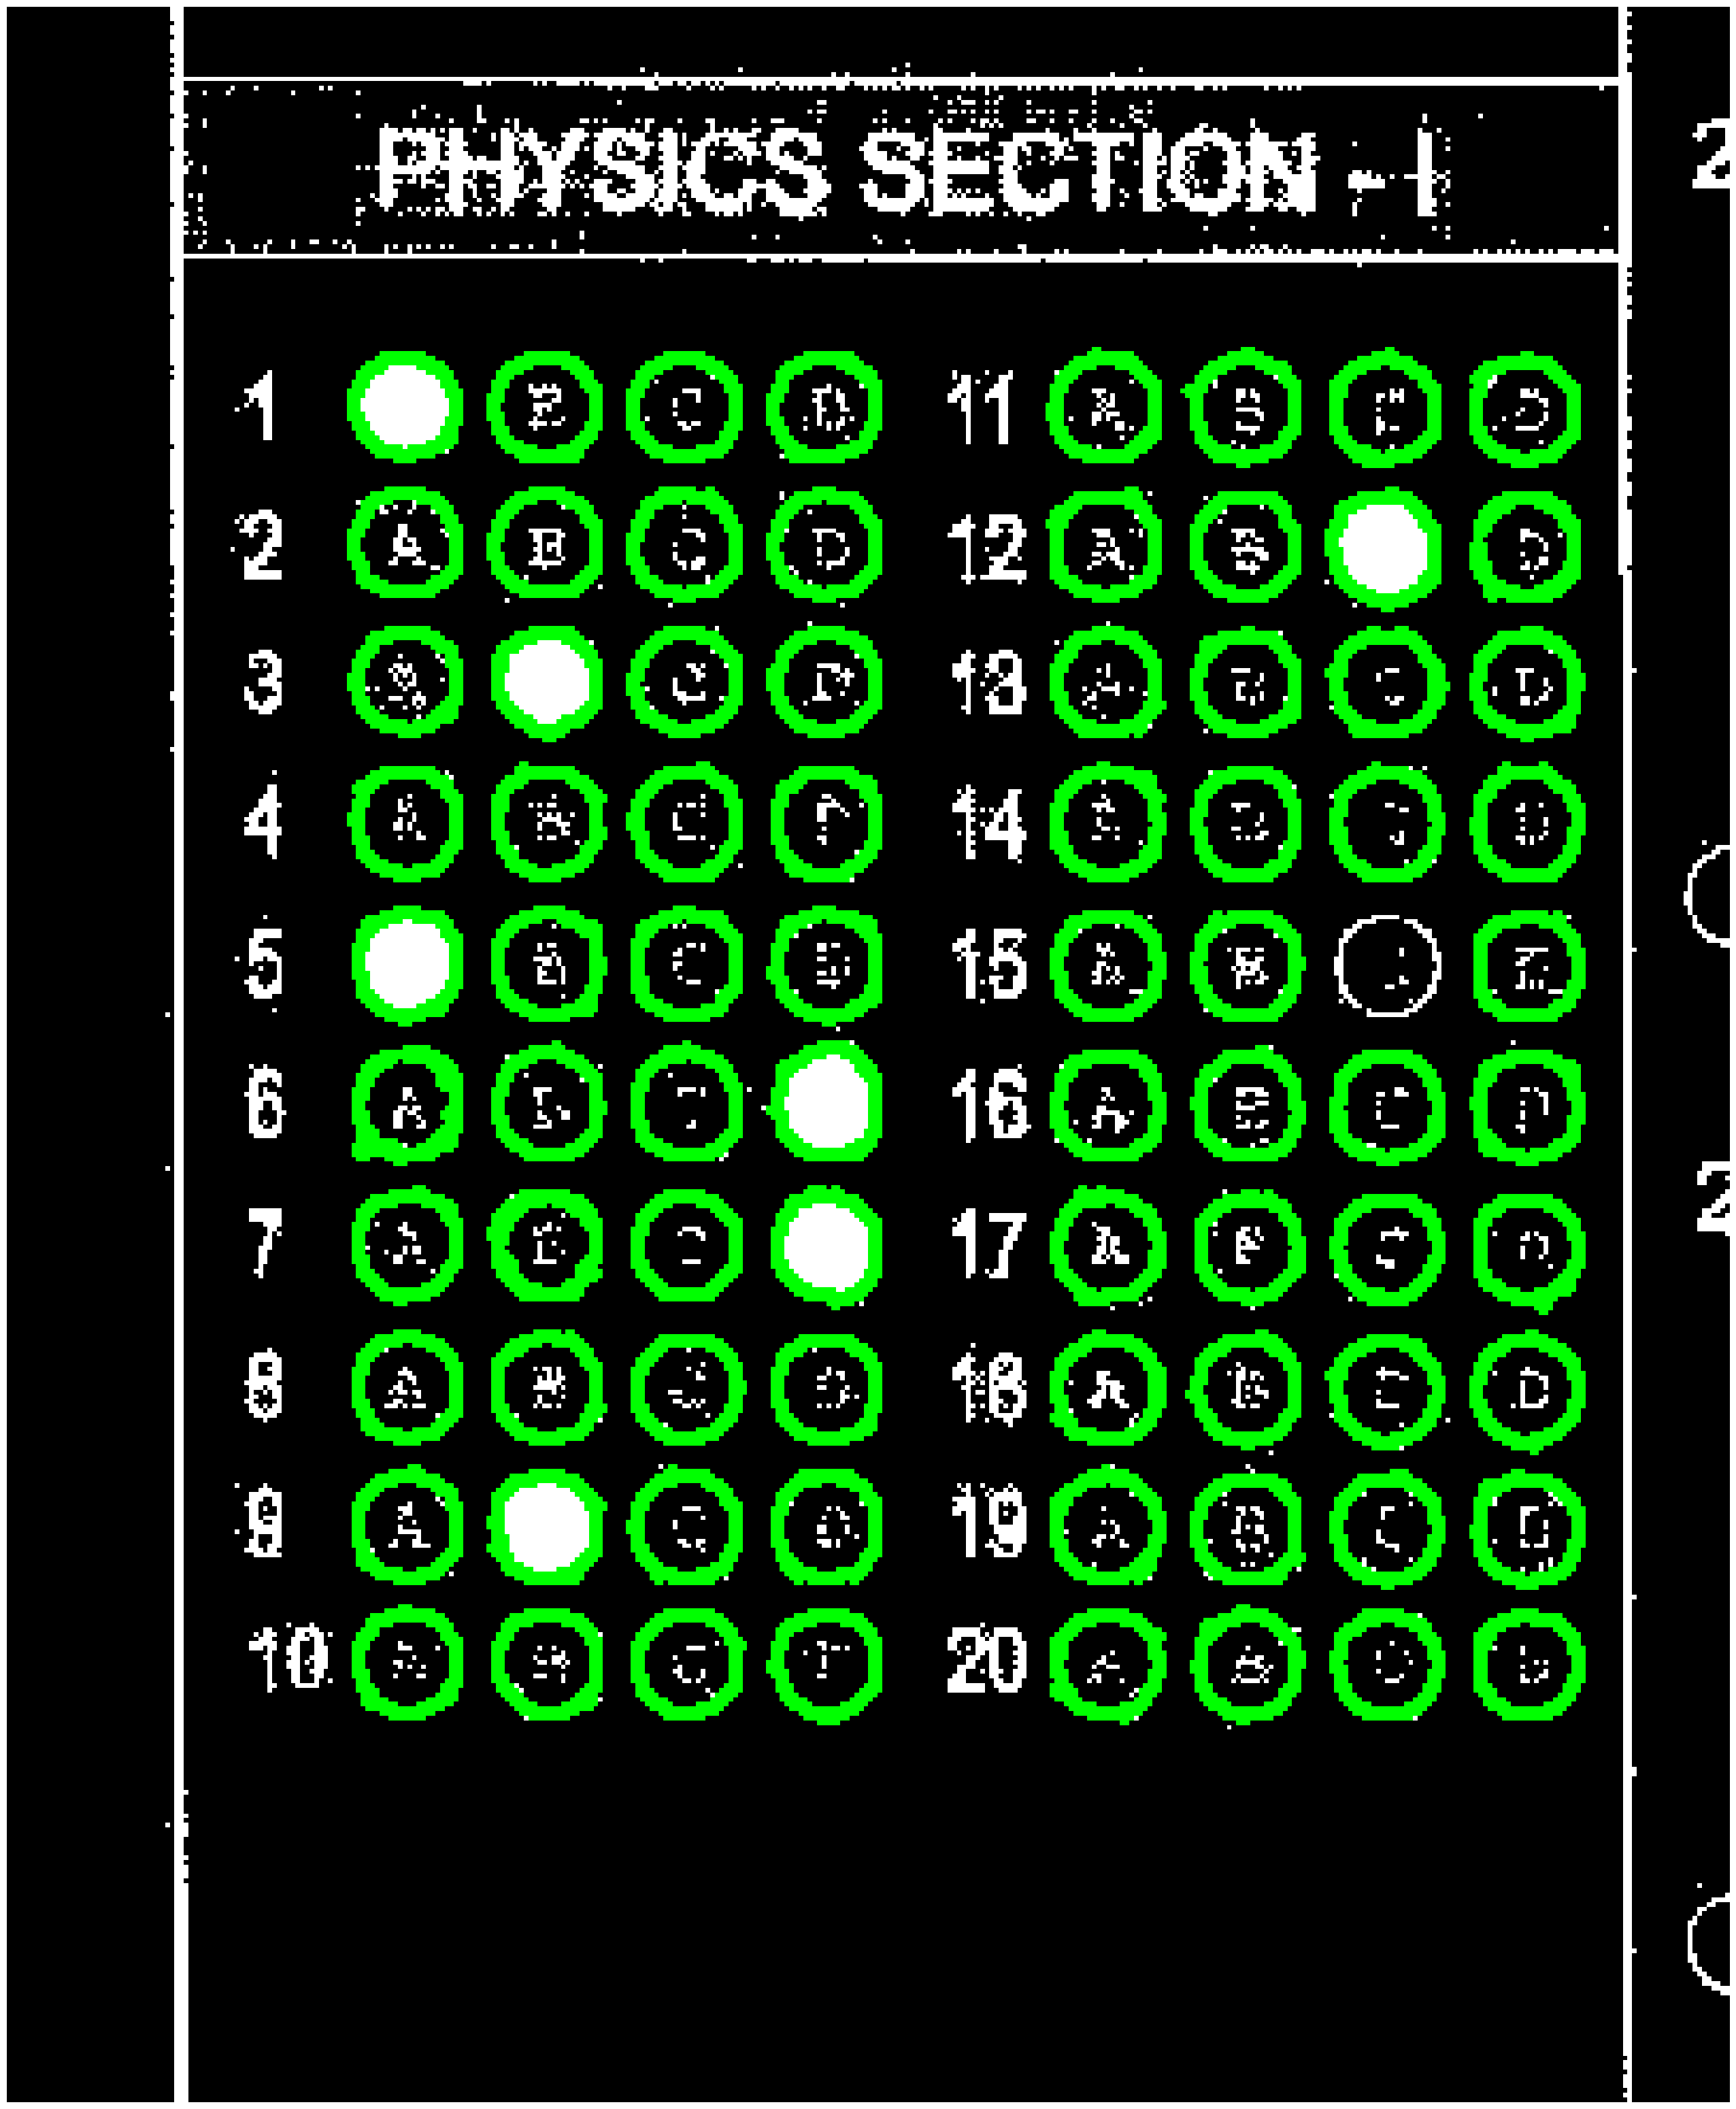

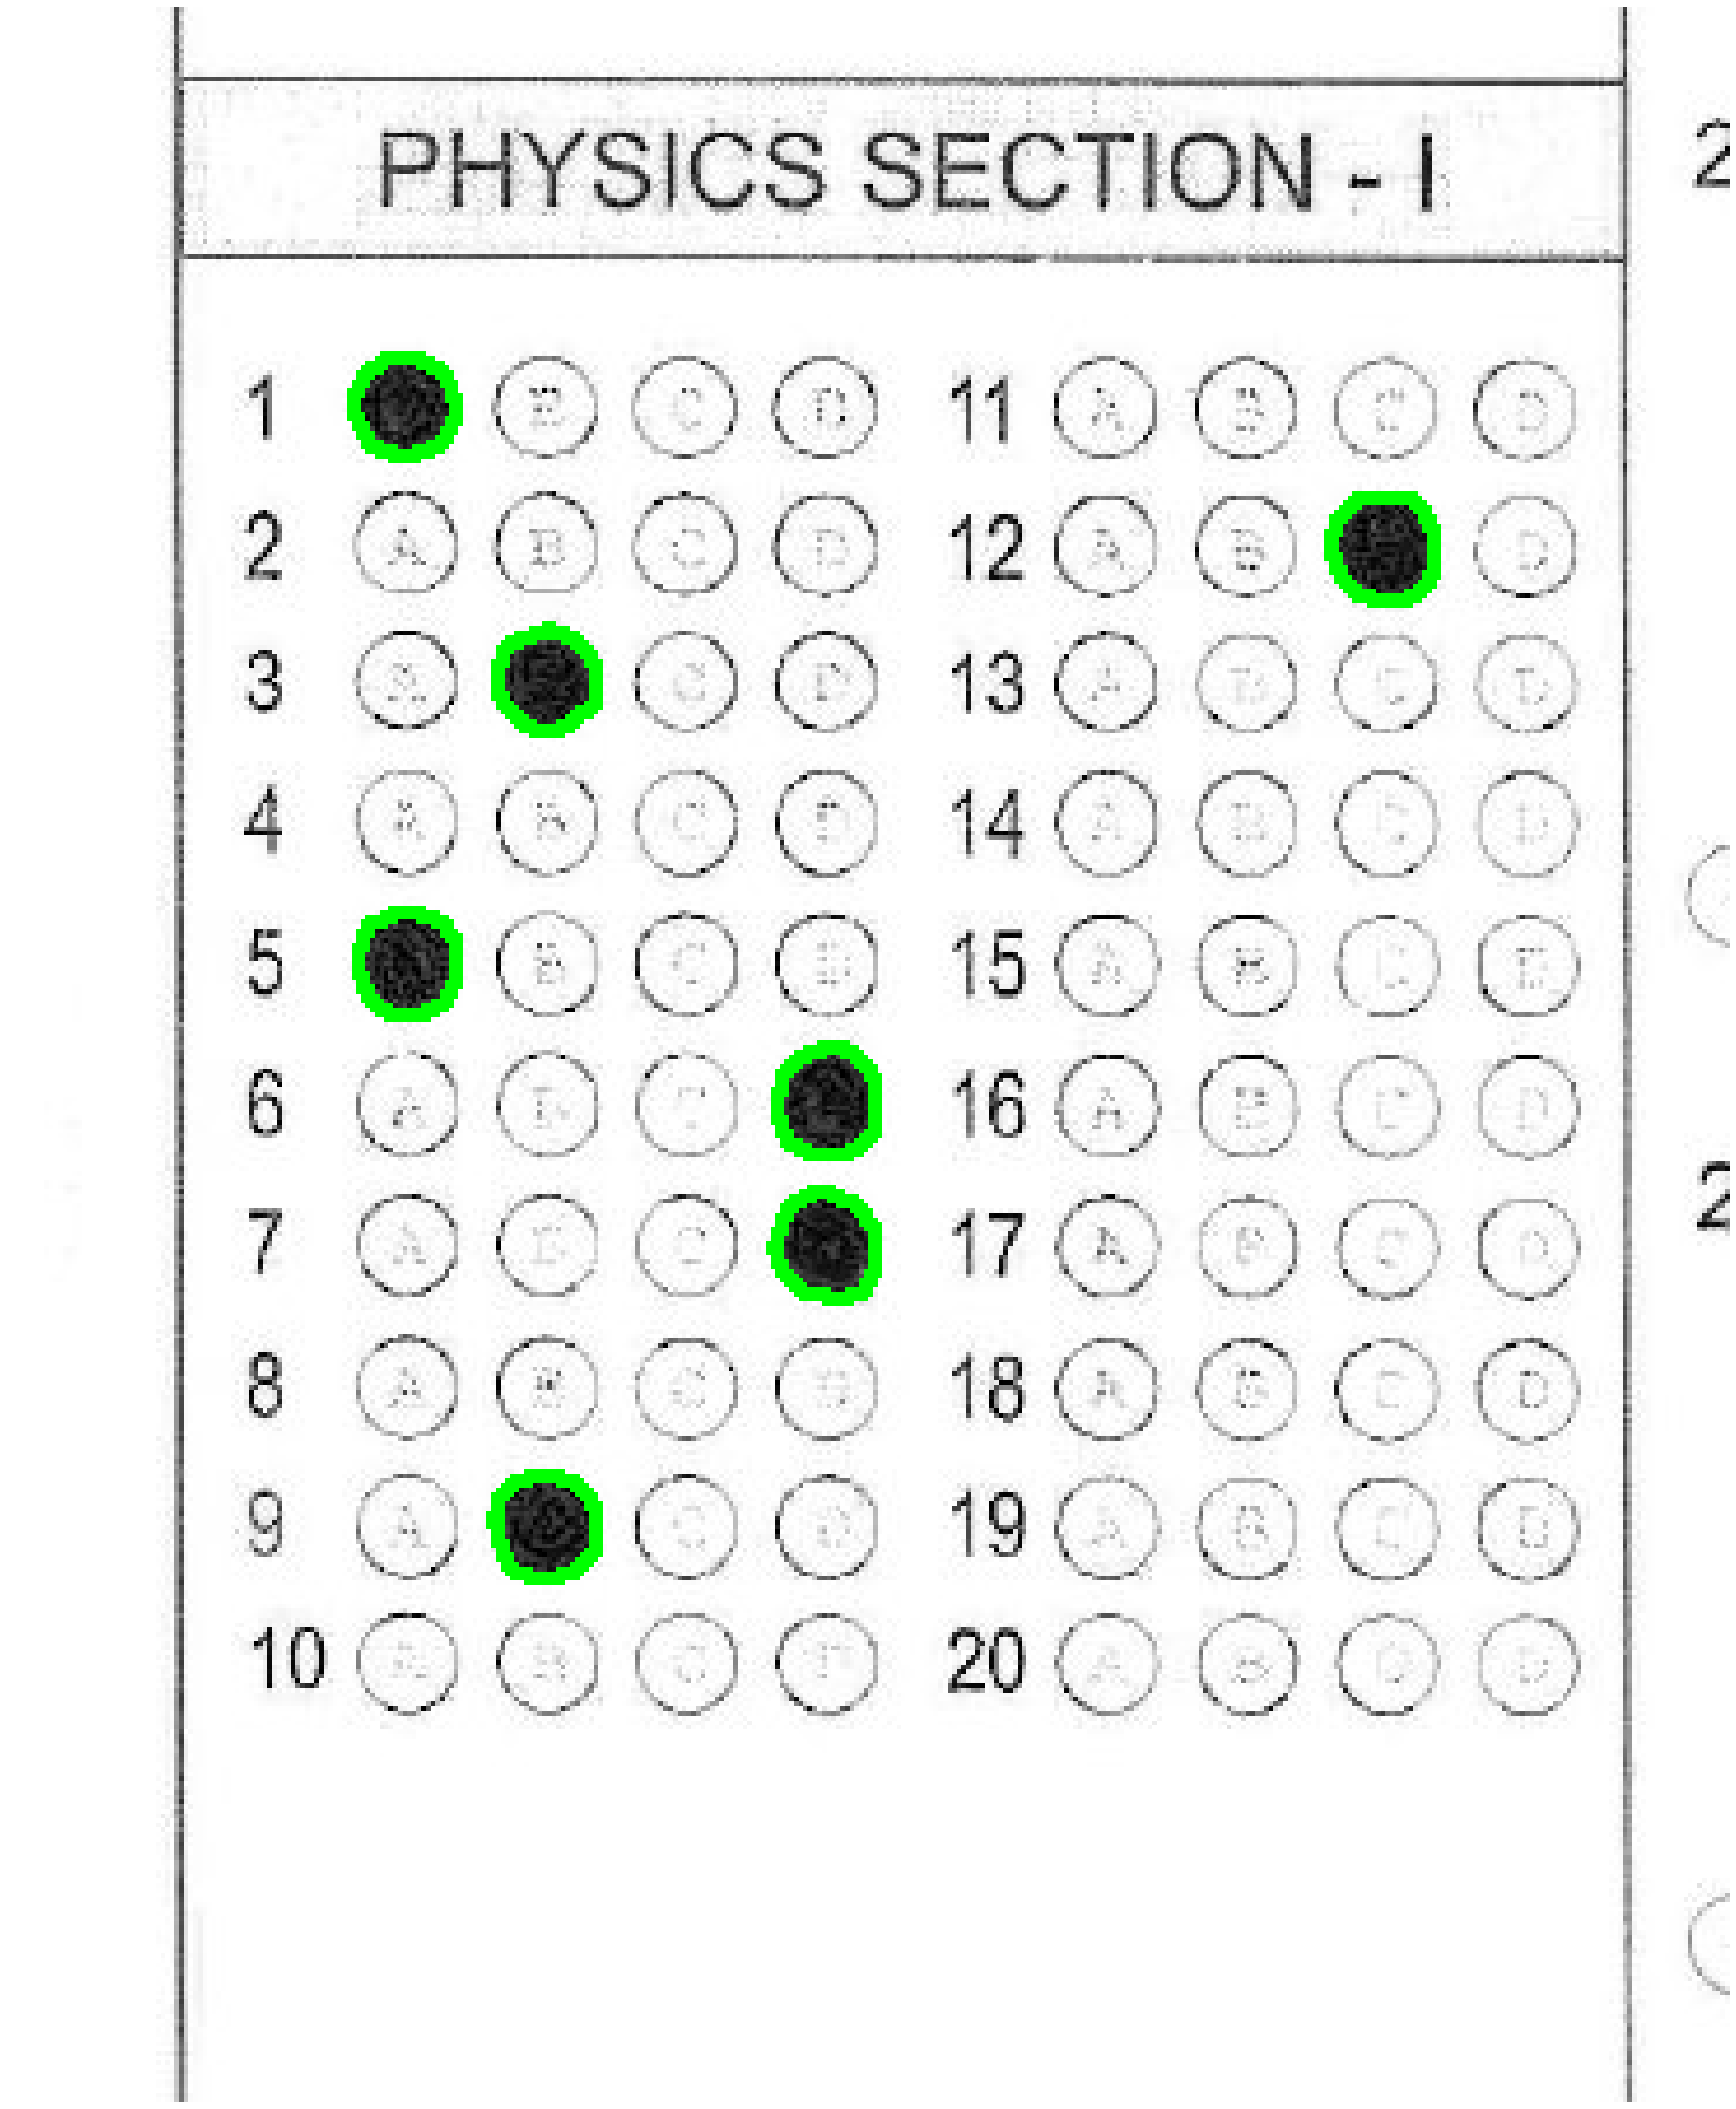

In [4]:
subject = phy_images[25]

notmarked = plotAllBubblesSection(subject)
marked = plotMarkedBulbblesSection(subject)

In [5]:
def ans_grid(image):

    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Apply adaptive thresholding to get a binary image
    thresh = cv2.adaptiveThreshold(blurred, 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY_INV, 
                                11, 5)

    # Find contours in the thresholded image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Prepare a list to hold the detected bubble contours
    bubble_contours = []

    # Loop over contours to filter out the bubbles
    for cnt in contours:
        # Compute the area and perimeter
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        
        # Skip small contours that are likely noise
        if area < 10:  # You may need to adjust this threshold based on your image resolution
            continue
        
        # Compute circularity
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        
        # Check if circularity is within a reasonable range (e.g., >0.7)
        if circularity > 0.8:
            bubble_contours.append(cnt)


    # Initialize lists to hold the boundary coordinates from each bubble contour.
    lefts = []
    rights = []
    tops = []
    bottoms = []

    # Iterate over each bubble contour.
    for cnt in bubble_contours:
        # Reshape the contour array to remove any extra dimensions.
        points = cnt.reshape(-1, 2)
        
        # Calculate boundaries for the current contour.
        left   = np.min(points[:, 0])  # Minimum x-coordinate.
        right  = np.max(points[:, 0])  # Maximum x-coordinate.
        top    = np.min(points[:, 1])  # Minimum y-coordinate.
        bottom = np.max(points[:, 1])  # Maximum y-coordinate.
        
        # Append the values to the corresponding lists.
        lefts.append(left)
        rights.append(right)
        tops.append(top)
        bottoms.append(bottom)

    # Convert the lists to NumPy arrays.
    lefts = np.array(lefts)
    rights = np.array(rights)
    tops = np.array(tops)
    bottoms = np.array(bottoms)

    # Define a helper function to perform KMeans clustering on a 1D array.
    def cluster_boundaries(values, n_clusters=8, random_state=42):
        values = np.array(values)  # Ensure it's a NumPy array.
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans.fit(values.reshape(-1, 1))
        return kmeans.cluster_centers_, kmeans.labels_

    # Cluster the left boundaries.
    cluster_centers_left, labels_left = cluster_boundaries(lefts, n_clusters=8)
    # Cluster the right boundaries.
    cluster_centers_right, labels_right = cluster_boundaries(rights, n_clusters=8)
    # Cluster the top boundaries.
    cluster_centers_top, labels_top = cluster_boundaries(tops, n_clusters=10)
    # Cluster the bottom boundaries.
    cluster_centers_bottom, labels_bottom = cluster_boundaries(bottoms, n_clusters=10)

    sorted_left   = np.sort(cluster_centers_left.flatten()).astype(int)
    sorted_right  = np.sort(cluster_centers_right.flatten()).astype(int)
    sorted_top    = np.sort(cluster_centers_top.flatten()).astype(int)
    sorted_bottom = np.sort(cluster_centers_bottom.flatten()).astype(int)

    num_columns = len(sorted_left)
    num_rows = len(sorted_top)

    grid_cells = []
    size = 0
    margin = 5

    for i in range(num_rows):
        y_start, y_end = sorted_top[i], sorted_bottom[i] + size + margin
        row_cells = []
        row_image = image[y_start:y_end, :]
        
        for j in range(num_columns):
            x_start, x_end = sorted_left[j], sorted_right[j] + size + margin
            row_cells.append(row_image[:, x_start:x_end])
        
        grid_cells.append(row_cells)
            
            
    # print(f"Total cells extracted: {len(grid_cells)}")

    # grid_cells = np.array(grid_cells)

    # If you want to visualize all cells in a grid layout (for example using matplotlib):
    # import matplotlib.pyplot as plt

    # fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 12))
    # for i in range(num_rows):
    #     for j in range(num_columns):
    #         axs[i, j].imshow(grid_cells[i][j],cmap='gray')
    #         axs[i, j].axis('off')
    # plt.tight_layout()
    # plt.show()


    binary_grid = []
    threshold = 200

    for row in grid_cells:
        binary_row = []
        for cell in row:
            summation = np.sum(cell)
            expected_sum = cell.shape[0] * cell.shape[1] * threshold
            if summation < expected_sum:
                binary_row.append(1)
            else:
                binary_row.append(0)
        binary_grid.append(binary_row)
        
    binary_grid = np.array(binary_grid)

    return np.concat([binary_grid[:,:4],binary_grid[:,4:]])



In [6]:
def getRoll(image):

    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Apply adaptive thresholding to get a binary image
    thresh = cv2.adaptiveThreshold(blurred, 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY_INV, 
                                11, 5)

    # Find contours in the thresholded image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Prepare a list to hold the detected bubble contours
    bubble_contours = []

    # Loop over contours to filter out the bubbles
    for cnt in contours:
        # Compute the area and perimeter
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        
        # Skip small contours that are likely noise
        if area < 10:  # You may need to adjust this threshold based on your image resolution
            continue
        
        # Compute circularity
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        
        # Check if circularity is within a reasonable range (e.g., >0.7)
        if circularity > 0.8:
            bubble_contours.append(cnt)


    # Initialize lists to hold the boundary coordinates from each bubble contour.
    lefts = []
    rights = []
    tops = []
    bottoms = []

    # Iterate over each bubble contour.
    for cnt in bubble_contours:
        # Reshape the contour array to remove any extra dimensions.
        points = cnt.reshape(-1, 2)
        
        # Calculate boundaries for the current contour.
        left   = np.min(points[:, 0])  # Minimum x-coordinate.
        right  = np.max(points[:, 0])  # Maximum x-coordinate.
        top    = np.min(points[:, 1])  # Minimum y-coordinate.
        bottom = np.max(points[:, 1])  # Maximum y-coordinate.
        
        # Append the values to the corresponding lists.
        lefts.append(left)
        rights.append(right)
        tops.append(top)
        bottoms.append(bottom)

    # Convert the lists to NumPy arrays.
    lefts = np.array(lefts)
    rights = np.array(rights)
    tops = np.array(tops)
    bottoms = np.array(bottoms)

    # Define a helper function to perform KMeans clustering on a 1D array.
    def cluster_boundaries(values, n_clusters=8, random_state=42):
        values = np.array(values)  # Ensure it's a NumPy array.
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans.fit(values.reshape(-1, 1))
        return kmeans.cluster_centers_, kmeans.labels_

    # Cluster the left boundaries.
    cluster_centers_left, labels_left = cluster_boundaries(lefts, n_clusters=10)
    # Cluster the right boundaries.
    cluster_centers_right, labels_right = cluster_boundaries(rights, n_clusters=10)
    # Cluster the top boundaries.
    cluster_centers_top, labels_top = cluster_boundaries(tops, n_clusters=10)
    # Cluster the bottom boundaries.
    cluster_centers_bottom, labels_bottom = cluster_boundaries(bottoms, n_clusters=10)

    sorted_left   = np.sort(cluster_centers_left.flatten()).astype(int)
    sorted_right  = np.sort(cluster_centers_right.flatten()).astype(int)
    sorted_top    = np.sort(cluster_centers_top.flatten()).astype(int)
    sorted_bottom = np.sort(cluster_centers_bottom.flatten()).astype(int)

    num_columns = len(sorted_left)
    num_rows = len(sorted_top)

    grid_cells = []
    size = 0
    margin = 5

    for i in range(num_rows):
        y_start, y_end = sorted_top[i], sorted_bottom[i] + size + margin
        row_cells = []
        row_image = image[y_start:y_end, :]
        
        for j in range(num_columns):
            x_start, x_end = sorted_left[j], sorted_right[j] + size + margin
            row_cells.append(row_image[:, x_start:x_end])
        
        grid_cells.append(row_cells)
        
        
    # grid_cells = np.array(grid_cells)

    # If you want to visualize all cells in a grid layout (for example using matplotlib):
    # import matplotlib.pyplot as plt

    # fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 12))
    # for i in range(num_rows):
    #     for j in range(num_columns):
    #         axs[i, j].imshow(grid_cells[i][j],cmap='gray')
    #         axs[i, j].axis('off')
    # plt.tight_layout()
    # plt.show()
        
    binary_grid = []
    threshold = 200

    for row in grid_cells:
        binary_row = []
        for cell in row:
            summation = np.sum(cell)
            expected_sum = cell.shape[0] * cell.shape[1] * threshold
            if summation < expected_sum:
                binary_row.append(1)
            else:
                binary_row.append(0)
        binary_grid.append(binary_row)
        
    binary_grid = np.array(binary_grid)
    
    
    
    rollnumber = ""
    
    for i in range(10):
        counter = 0
        for j in binary_grid[:,i]:
            if(j == 1):
                rollnumber+=str(counter)
                break
            counter+=1
    
    return int(rollnumber)

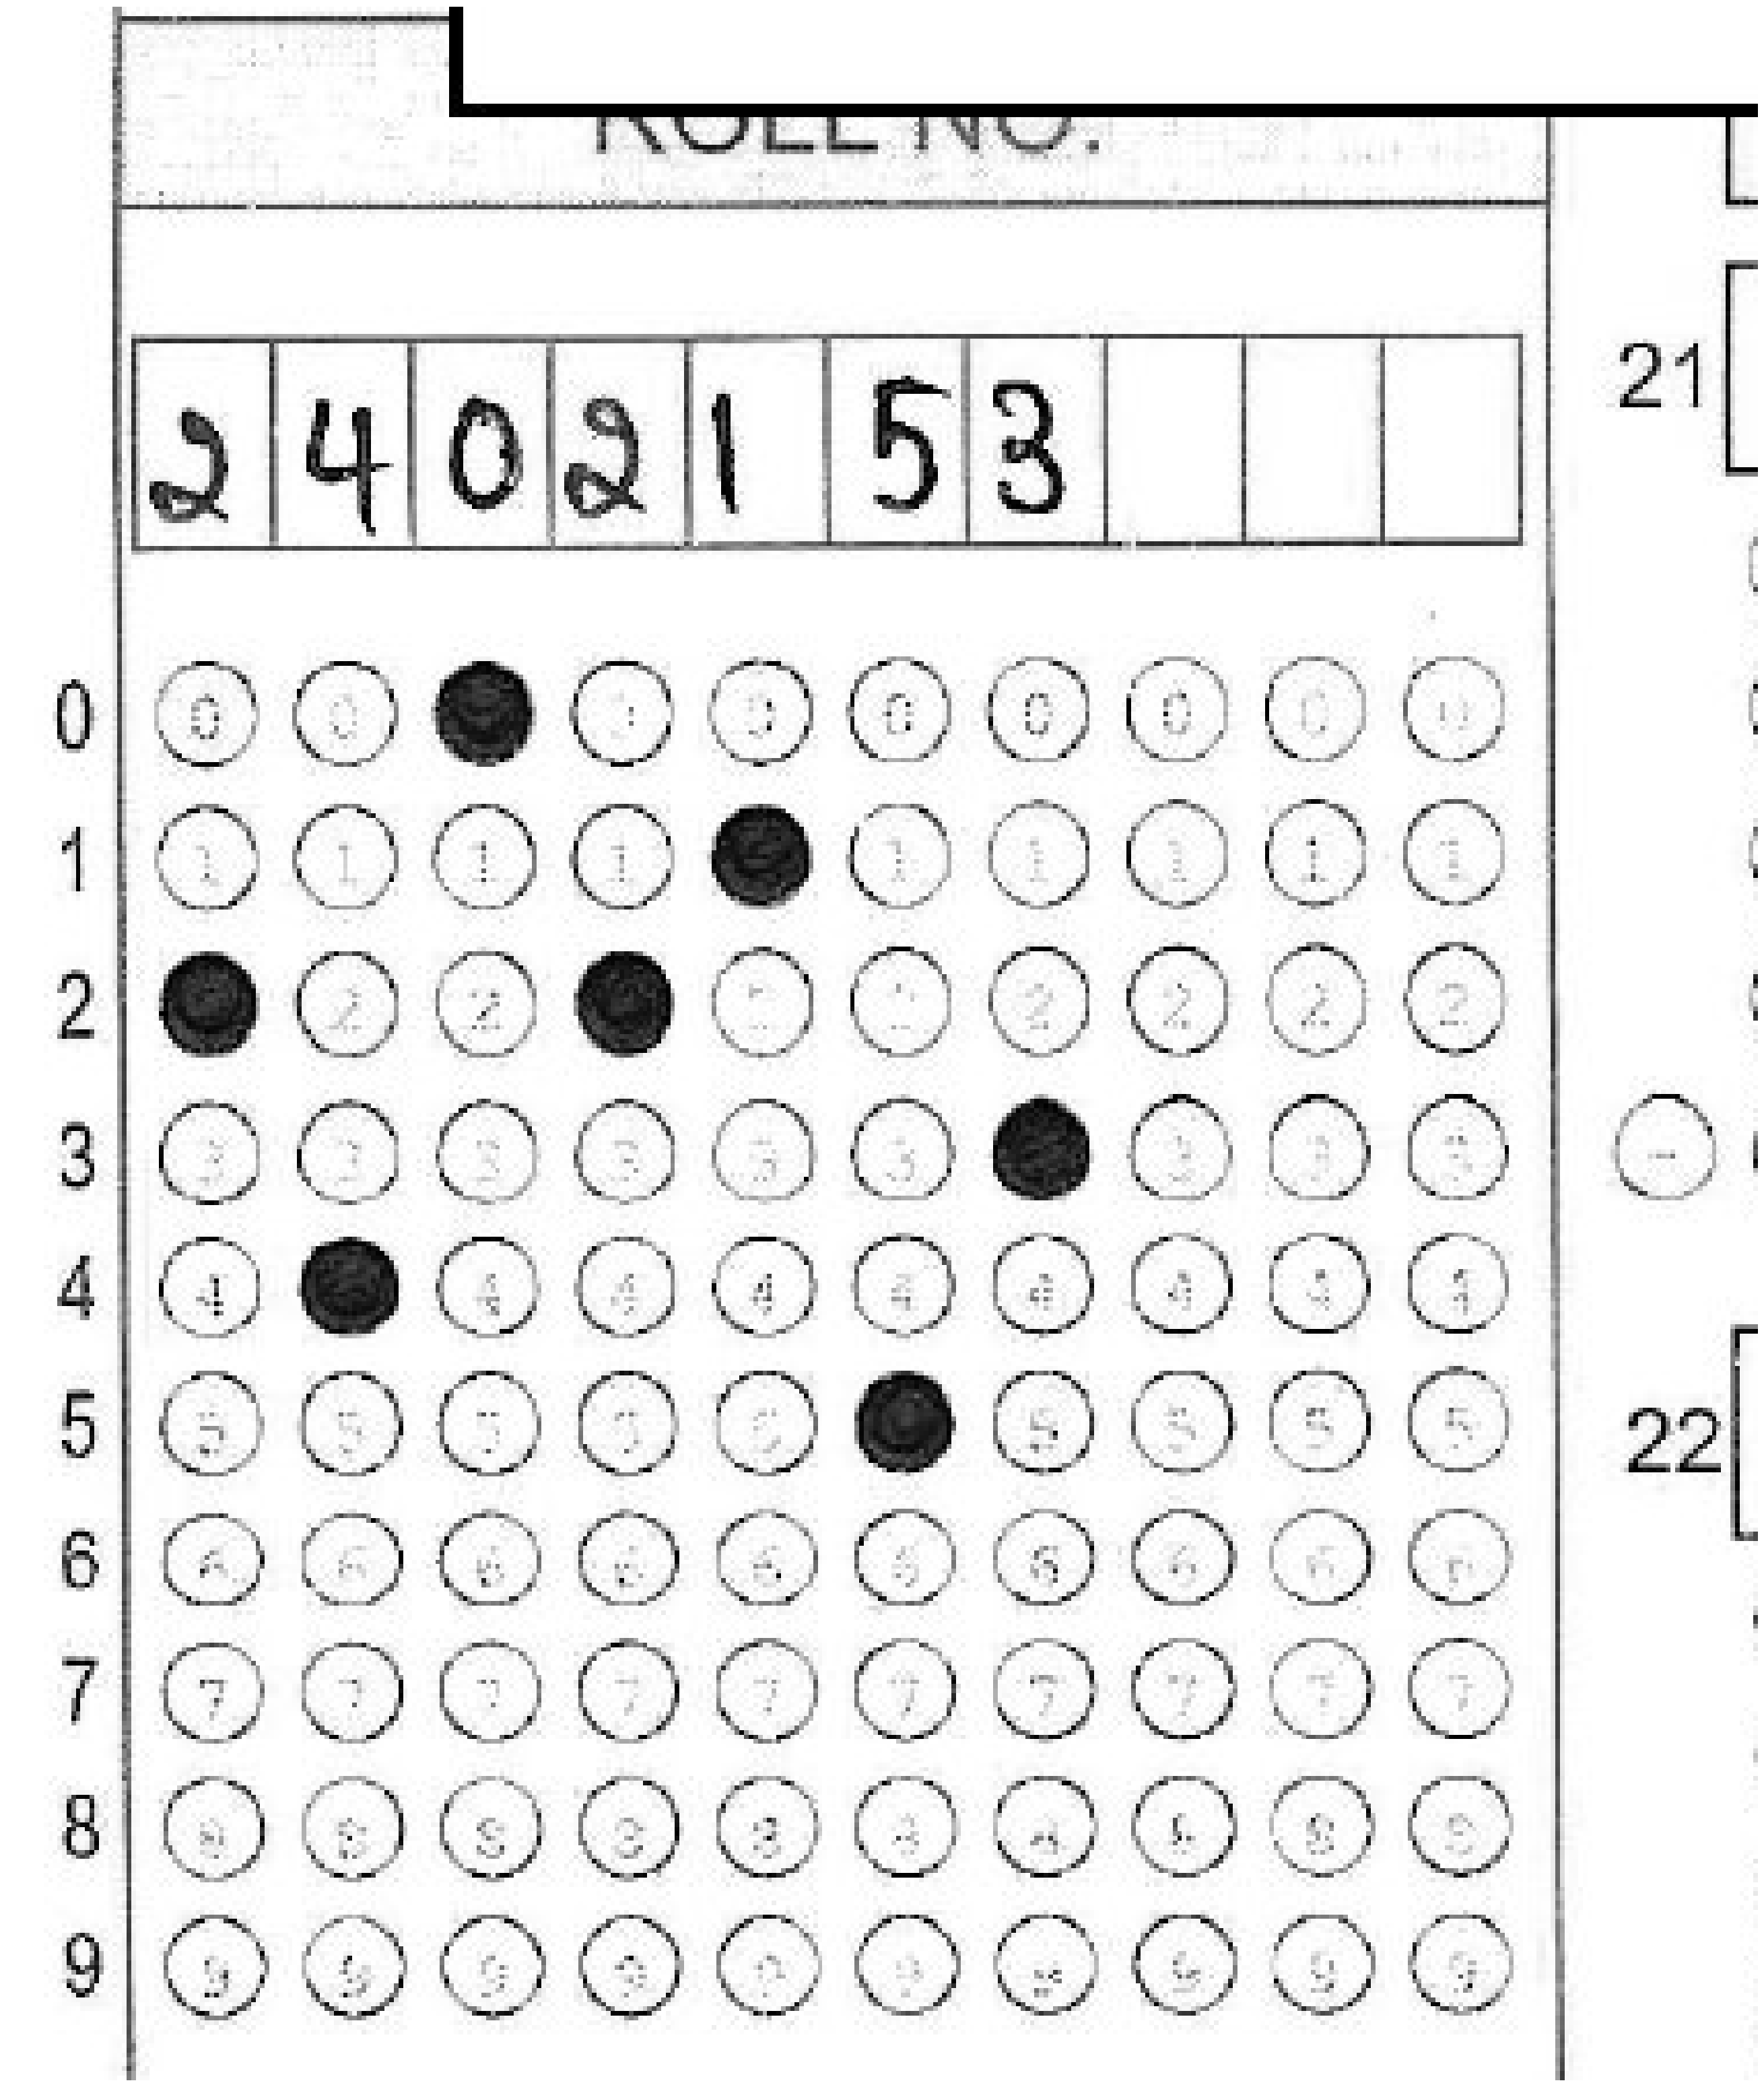

2402153


In [7]:
image_path = f'./OMR_dataset/images/omr_aiml_dataset_page_{30}.png'
image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
grid = getRoll(image[200:650,0:380])
show_img(image[200:650,0:380])
print(grid)

In [8]:
import pandas as pd
responses = pd.read_csv('./OMR_dataset/csv/omr_ai_responses.csv')
# print(responses)

overall_correct = 0

for i in range(30,40):
    image_path = f'./OMR_dataset/images/omr_aiml_dataset_page_{i}.png'
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image,(1700,2624))
    
    roll = getRoll(image[200:650,0:380]) 
    phy_section = image[1150:1600,:370]
    chem_section = image[1600:2000,:370]
    math_section = image[2100:2500,:370]
    phy_mat = list(ans_grid(phy_section))
    chem_mat = list(ans_grid(chem_section))
    math_mat = list(ans_grid(math_section))
    # show_img(math_section)
    # print(math_mat)
    
    data = responses[responses['ID NO']==roll]
    
    
    response_dict = {'A':list([1,0,0,0]),'B':[0,1,0,0],'C':[0,0,1,0],'D':[0,0,0,1]}
    correct = 0
    for que in range(1, 21):
        expected = response_dict.get(data[f'Q{que}'].iloc[0], [0, 0, 0, 0])
        if expected == list(phy_mat[que - 1]):  
            correct += 1


    
    for que in range(31, 51):
        expected = response_dict.get(data[f'Q{que}'].iloc[0], [0, 0, 0, 0])
        if expected == list(chem_mat[que - 31]):  
            correct += 1
    
    for que in range(61, 81):
        expected = response_dict.get(data[f'Q{que}'].iloc[0], [0, 0, 0, 0])
        # print(expected,math_mat[que - 61])
        if expected == list(math_mat[que - 61]):  
            correct += 1
    
    print(image_path,"Correct out of 60:",correct)
    overall_correct+=correct
    
    # break

print(overall_correct/(10*60)  * 100)


./OMR_dataset/images/omr_aiml_dataset_page_30.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_31.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_32.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_33.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_34.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_35.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_36.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_37.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_38.png Correct out of 60: 60
./OMR_dataset/images/omr_aiml_dataset_page_39.png Correct out of 60: 60
100.0


In [2]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 4.2 MB/s eta 0:00:0000:0100:01


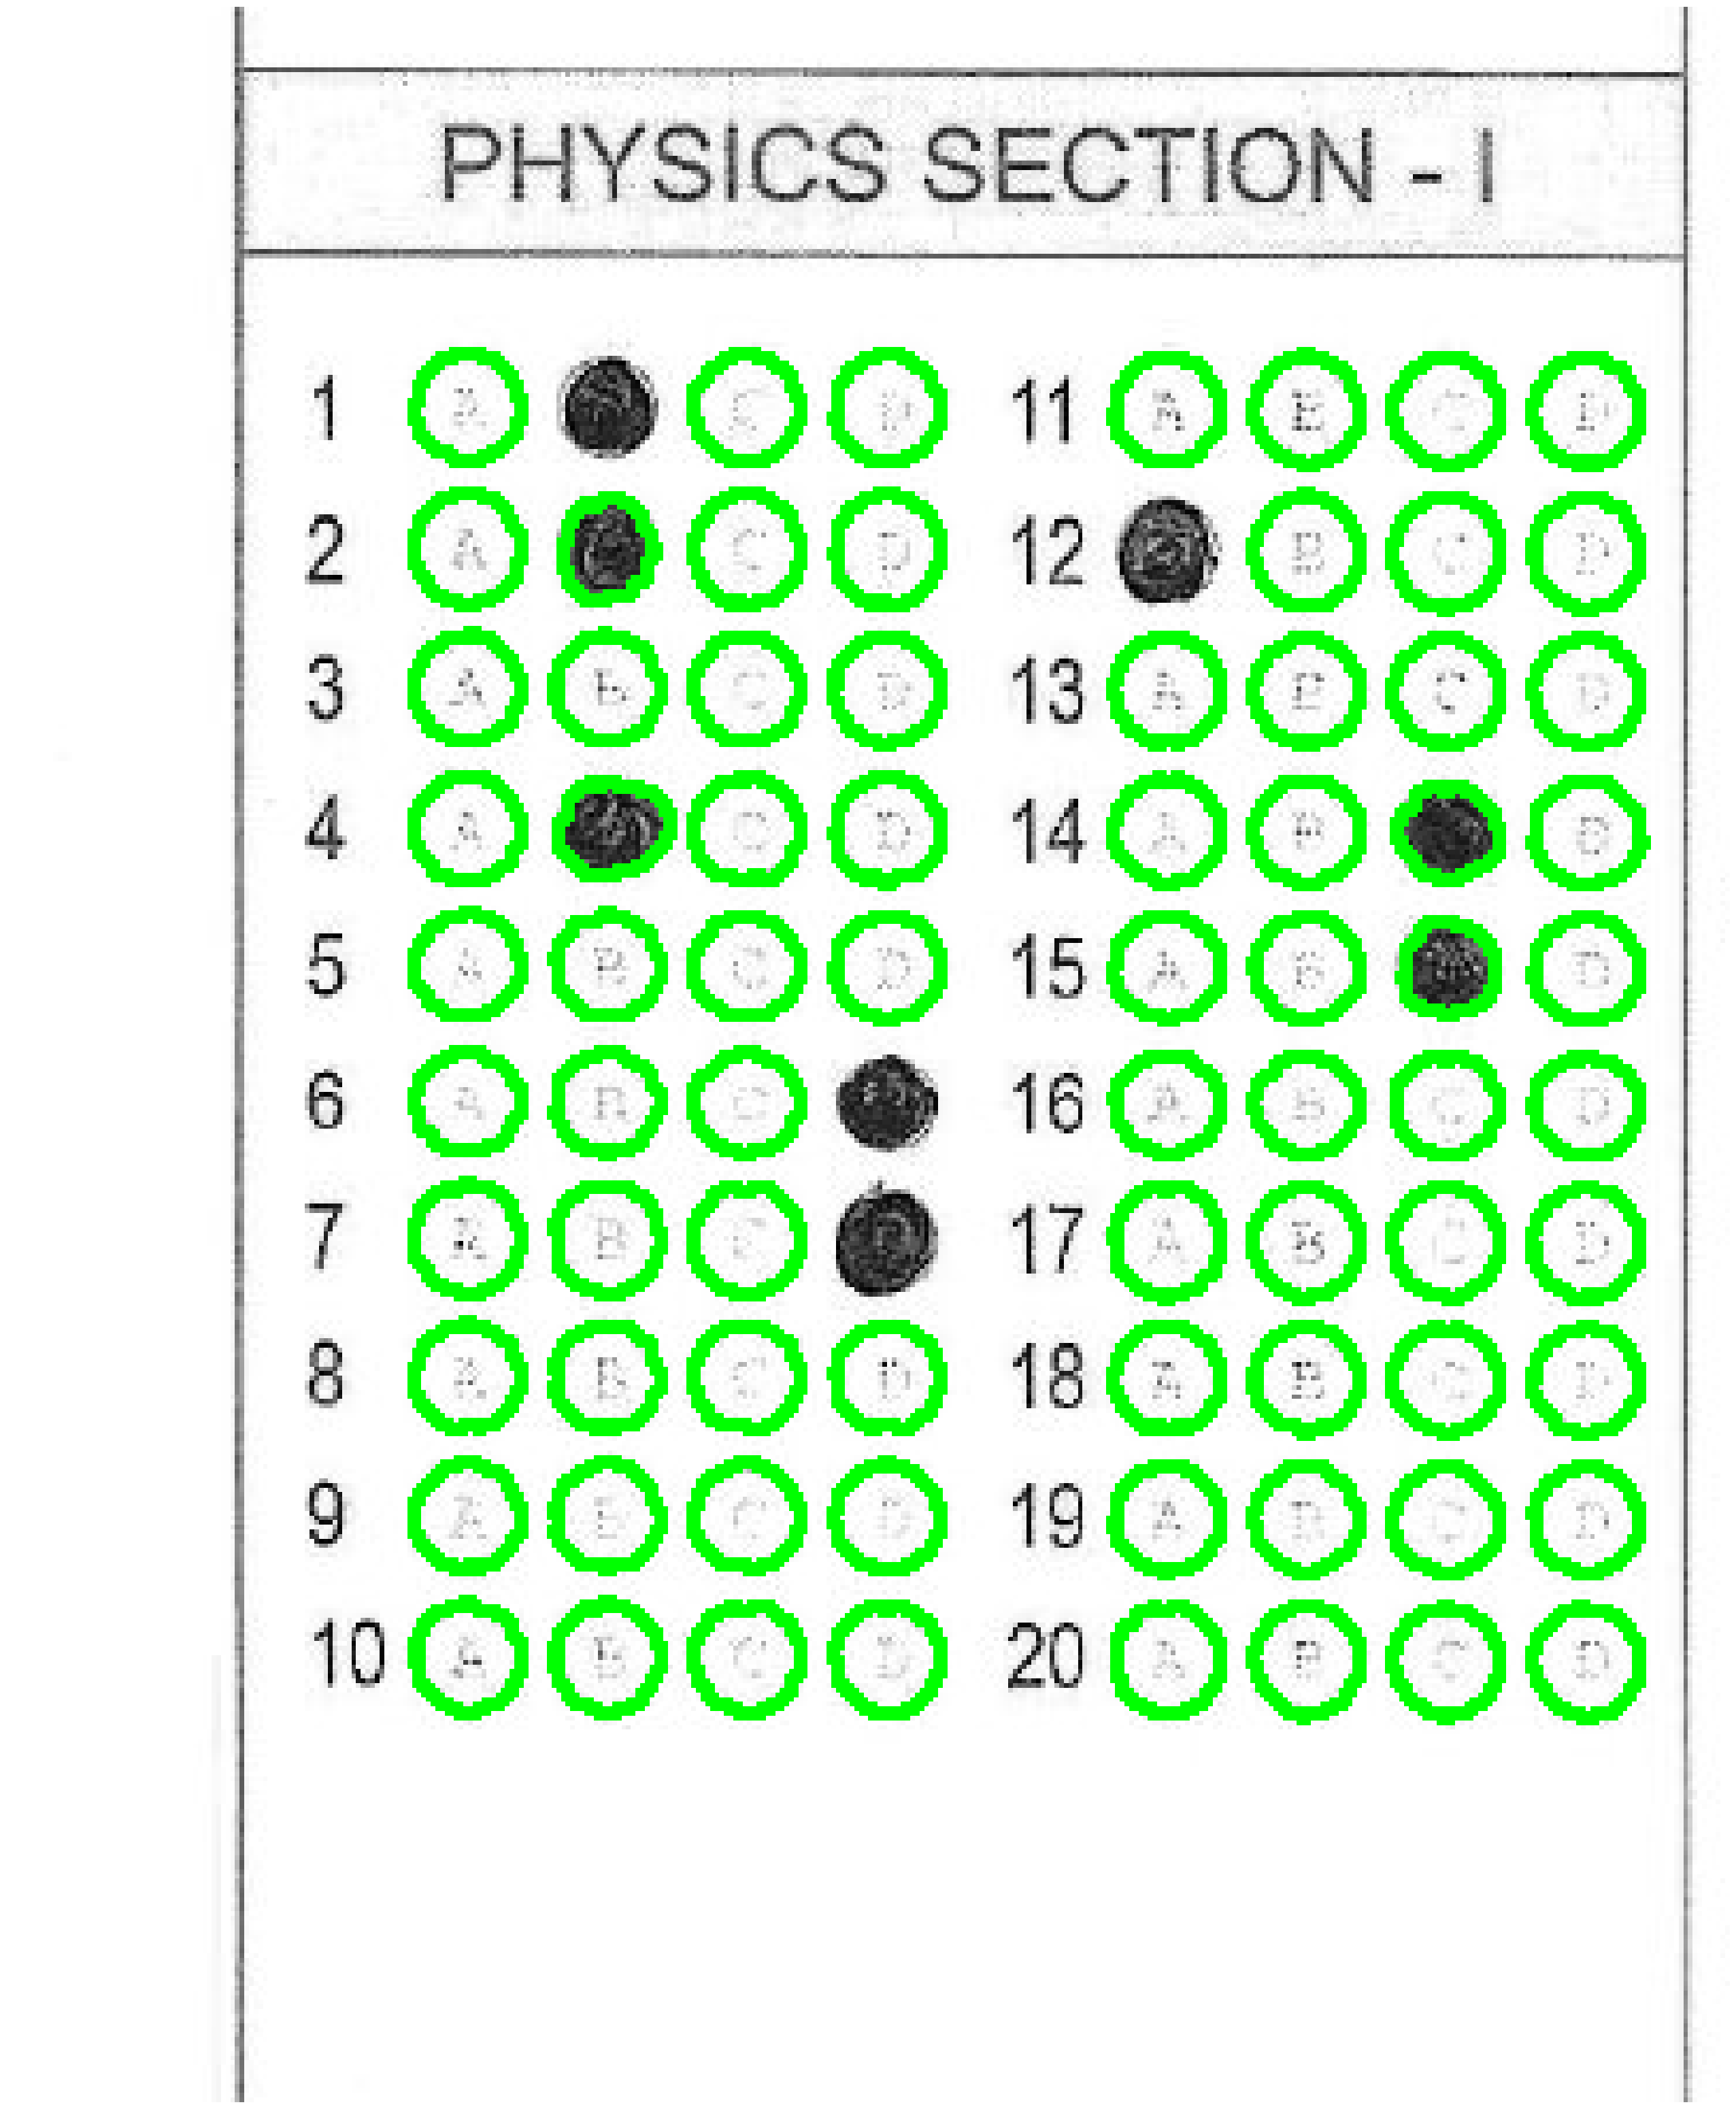

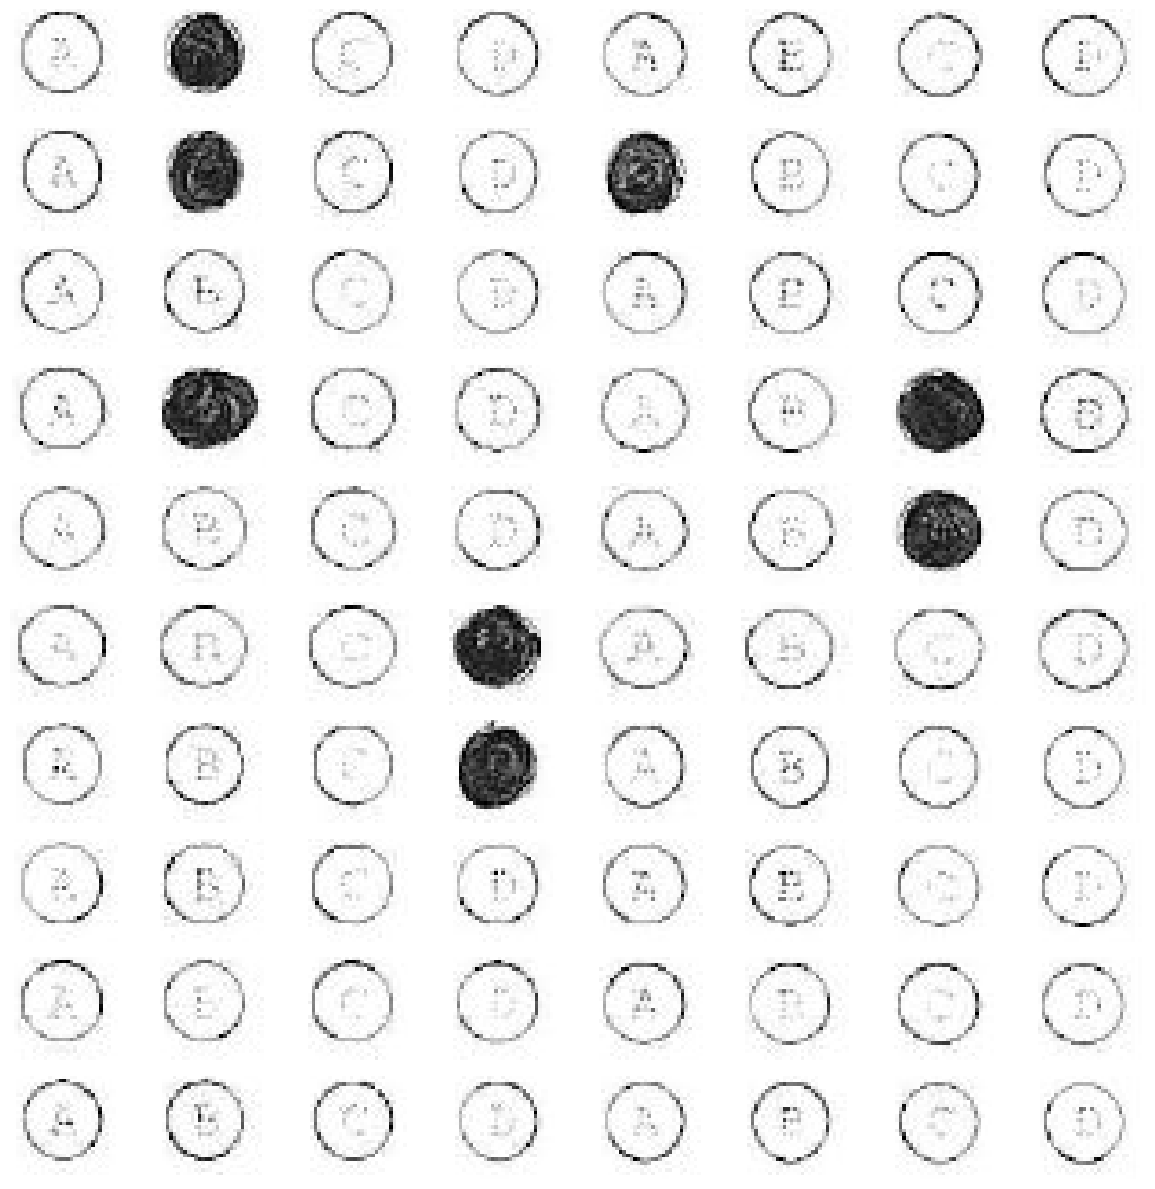

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the image
image = phy_images[0]

# Apply Gaussian blur
blurred = cv2.GaussianBlur(image, (3, 3), 0)

# Apply adaptive thresholding
thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 5
)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter bubble contours
bubble_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if area < 10 or perimeter == 0:
        continue
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    if circularity > 0.8:
        bubble_contours.append(cnt)

# Draw contours
output = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
cv2.drawContours(output, bubble_contours, -1, (0, 255, 0), 2)
show_img(output)

# Extract boundary coordinates
lefts, rights, tops, bottoms = [], [], [], []
for cnt in bubble_contours:
    points = cnt.reshape(-1, 2)
    lefts.append(np.min(points[:, 0]))
    rights.append(np.max(points[:, 0]))
    tops.append(np.min(points[:, 1]))
    bottoms.append(np.max(points[:, 1]))

lefts, rights, tops, bottoms = map(np.array, [lefts, rights, tops, bottoms])

def cluster_boundaries(values, n_clusters=8, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(values.reshape(-1, 1))
    return np.sort(kmeans.cluster_centers_.flatten().astype(int))

# Cluster boundaries
sorted_left = cluster_boundaries(lefts, n_clusters=8)
sorted_right = cluster_boundaries(rights, n_clusters=8)
sorted_top = cluster_boundaries(tops, n_clusters=10)
sorted_bottom = cluster_boundaries(bottoms, n_clusters=10)

# Extract grid cells
grid_cells, margin = [], 5
num_rows, num_columns = len(sorted_top), len(sorted_left)
for i in range(num_rows):
    y_start, y_end = sorted_top[i], sorted_bottom[i] + margin
    row_cells = []
    row_image = image[y_start:y_end, :]
    for j in range(num_columns):
        x_start, x_end = sorted_left[j], sorted_right[j] + margin
        row_cells.append(row_image[:, x_start:x_end])
    grid_cells.append(row_cells)

# Display extracted cells
fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 12))
for i in range(num_rows):
    for j in range(num_columns):
        axs[i, j].imshow(grid_cells[i][j], cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [70]:
binary_grid = []
threshold = 200  # Adjust if needed

for row in grid_cells:
    binary_row = []
    for cell in row:
        summation = np.sum(cell)
        # print(summation)
        expected_sum = cell.shape[0] * cell.shape[1] * threshold

        if summation < expected_sum:
            binary_row.append(1)
        else:
            binary_row.append(0)

    binary_grid.append(binary_row)
    
binary_grid = np.array(binary_grid)

print(np.concat([binary_grid[:,:4],binary_grid[:,4:]]))


[[0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
